# Bangalore Housing Price Prediction and EDA

This project focuses on forecasting housing prices in Bangalore by applying sophisticated machine learning techniques. We start by extensively exploring and cleaning the data, then proceed to feature engineering to improve model effectiveness. The project concludes with the creation and assessment of multiple predictive models, including an ensemble model that achieves impressive accuracy.


## 1. Initial Setup

First, we import the dataset and all necessary packages.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import fuzzywuzzy for text matching
from fuzzywuzzy import fuzz, process

# Import machine learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score
from scipy import stats

c:\Users\91931\Real-Estate-Price-Prediction\virtual\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## 2. Initial Data Exploration

We begin by reading the dataset and performing initial exploratory data analysis (EDA). We examine the first 10 entries to understand the data types (string or float) and the number of columns. This gives us an overview of the dataset's structure and helps identify any immediate issues.

In [2]:
df1 = pd.read_csv("data/Bengaluru_House_Data.csv")
df1.head(10)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170,2.0,1.0,38.00
6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732,4.0,NaN,204.00
7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,Brway G,3300,4.0,NaN,600.00
8,Super built-up Area,Ready To Move,Marathahalli,3 BHK,NaN,1310,3.0,1.0,63.25
9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00


## 3. Checking Data Shape
We check the shape of the dataset to understand the number of rows and columns. This step is crucial for planning our data cleaning and preprocessing strategies.

In [3]:
df1.shape

(13320, 9)

## 4. Handling Missing Values
Next, we check for null values in the dataset. This helps us decide on strategies to handle missing data.

In [4]:
df1.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

## 5. Dropping Irrelevant Columns

Based on domain knowledge, we decide to drop the `society` and `area_type` columns. The `society` column is merely the name of the building and doesn't hold significant value. The `area_type` column indicates whether the property is a plot, flat, or house, but this information doesn't significantly impact the property price. Instead, we will use the total square footage to derive meaningful insights.

In [5]:
df2 = df1.drop(['society', 'area_type'], axis='columns')
df2.head()

,availability,location,size,total_sqft,bath,balcony,price
0,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,51.00


## 6. Cleaning `total_sqft` Values

To ensure consistency in our dataset, we need to clean and standardize the `total_sqft` values, which are currently in various units and formats.

### Step 1: Standardizing `total_sqft` Values

The dataset contains `total_sqft` values in different units (square meters, square yards) and formats (ranges). To ensure consistency, we need to standardize these values to a single float format.

In [6]:
df2['total_sqft'].unique()

# Extract unique values
unique_values = df2['total_sqft'].unique()

# Categorize values
floats = []
ranges = []
strings = []
unknown = []

for value in unique_values:
    try:
        # Try to convert to float
        float_value = float(value)
        floats.append(value)
    except ValueError:
        # Check if it is a range
        if '-' in value and all(part.strip().replace('.', '', 1).isdigit() for part in value.split('-')):
            ranges.append(value)
        else:
            try:
                # Check if it's a valid range format (e.g., '1133 - 1384')
                start, end = value.split('-')
                float(start.strip())
                float(end.strip())
                ranges.append(value)
            except (ValueError, IndexError):
                # If it doesn't fit float or range, classify it as string or unknown
                if value.isalpha() or not any(char.isdigit() for char in value):
                    strings.append(value)
                else:
                    unknown.append(value)

# Display categorized results
print("Floats:")
print(floats)
print("\nRanges:")
print(ranges)
print("\nStrings:")
print(strings)
print("\nUnknown:")
print(unknown)

Floats:
['1056', '2600', '1440', '1521', '1200', '1170', '2732', '3300', '1310', '1020', '1800', '2785', '1000', '1100', '2250', '1175', '1180', '1540', '2770', '600', '1755', '2800', '1767', '510', '1250', '660', '1610', '1151', '1025', '1075', '1760', '1693', '1925', '700', '1070', '1724', '1290', '1143', '1296', '1254', '1330.74', '970', '1459', '800', '869', '1270', '1670', '2010', '1185', '1600', '1500', '1407', '840', '4395', '845', '5700', '1160', '3000', '1140', '1220', '1350', '1005', '500', '1358', '1569', '1240', '2089', '1206', '1150', '2511', '460', '4400', '1660', '1326', '1325', '1499', '1665', '708', '1060', '710', '1450', '2894', '1330', '2502', '650', '2400', '1007', '966', '1630', '1640', '782', '1260', '1413', '1116', '1530', '3700', '2497', '1436', '276', '1427', '2061', '2650', '1282', '1050', '945', '950', '1870', '880', '1535', '1360', '1280', '5000', '3050', '1563.05', '1167', '4000', '1828', '890', '1612', '1034', '1710', '957', '2795', '1125', '1735', '2050',

### Step 2: Conversion Function for `total_sqft`

We create a function to handle the conversion of `total_sqft` values. This function uses a dictionary to map different units to a single unit (square feet). It first checks each data point for a unit and converts it if necessary. For range values, it calculates the mean of the range. Finally, it converts all values into floats for clean data points.

In [7]:
def convert_sqft_to_num(x):
    # Dictionary mapping units to their conversion factors to square feet
    conversion_factors = {
        'Sq. Meter': 10.7639,
        'Sq. Yard': 9,
        'Cent': 435.6,
        'Acre': 43560
    }

    # Check for unit and convert
    for unit, factor in conversion_factors.items():
        if unit in x:
            number = float(x.split(unit)[0].strip())
            return round(number * factor, 2)

    # Handle ranges of values
    tokens = x.split('-')
    if len(tokens) == 2:
        return round((float(tokens[0]) + float(tokens[1])) / 2, 2)

    # Handle direct conversion to float
    try:
        return round(float(x), 2)
    except ValueError:
        return None  # Return None if conversion fails

In [8]:
df2['total_sqft'] = df2['total_sqft'].apply(convert_sqft_to_num)
df2.head(20)

,availability,location,size,total_sqft,bath,balcony,price
0,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07
1,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00
2,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00
3,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00
4,Ready To Move,Kothanur,2 BHK,1200.0,2.0,1.0,51.00
5,Ready To Move,Whitefield,2 BHK,1170.0,2.0,1.0,38.00
6,18-May,Old Airport Road,4 BHK,2732.0,4.0,NaN,204.00
7,Ready To Move,Rajaji Nagar,4 BHK,3300.0,4.0,NaN,600.00
8,Ready To Move,Marathahalli,3 BHK,1310.0,3.0,1.0,63.25
9,Ready To Move,Gandhi Bazar,6 Bedroom,1020.0,6.0,NaN,370.00


## 7. Converting BHK Values
To maintain consistency, we convert the bhk (bedroom) values into float. This helps in standardizing different formats like '4 BHK', '3 Bedroom', etc.

In [9]:
# Extract number of bedrooms from size
df2['bhk'] = df2['size'].apply(lambda x: int(str(x).split(' ')[0]) if isinstance(x, str) else None)
df2.head()

,availability,location,size,total_sqft,bath,balcony,price,bhk
0,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2.0
1,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4.0
2,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3.0
3,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3.0
4,Ready To Move,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2.0


## 8. Handling Remaining Null Values

In a large dataset, it's often practical to drop rows with fewer counts of null values to maintain data integrity and ensure the quality of our analysis. Here's why we're specifically addressing null values in certain columns:



In [10]:
df2.isnull().sum()

availability      0
location          1
size             16
total_sqft        4
bath             73
balcony         609
price             0
bhk              16
dtype: int64

In [11]:
df3 = df2.dropna(subset=['location', 'size', 'total_sqft', 'bhk'])
df3.isnull().sum()

availability      0
location          0
size              0
total_sqft        0
bath             57
balcony         592
price             0
bhk               0
dtype: int64

## 9. Checking and Handling Unique Values in `bhk`

In this step, we focus on examining the `bhk` column. Ensuring the accuracy and consistency of this feature is crucial for building a reliable model. By analyzing the unique values within this column, we can identify and address any anomalies or outliers that may impact the quality of our dataset.

### Step 1: Identifying Anomalies in bhk Values

To ensure the quality and consistency of our dataset, we need to check the `bhk` values for any anomalies or outliers. The `bhk` column represents the number of bedrooms, halls, and kitchens in a property. Here's how we address unique values in this column

In [12]:
df3['bhk'].value_counts()

bhk
2.0     5528
3.0     4856
4.0     1417
1.0      654
5.0      355
6.0      221
7.0      100
8.0       89
9.0       53
10.0      14
11.0       4
27.0       1
19.0       1
16.0       1
43.0       1
14.0       1
12.0       1
13.0       1
18.0       1
Name: count, dtype: int64

### Step 2: Handling Outliers in bhk Values

we observed that the `bhk` column contains a small number of entries with values greater than 10. With only a few records exhibiting such values, they are not representative of typical properties in the dataset. Extreme values like 27 or more are uncommon in standard real estate markets and may result from data entry errors or rare cases. Removing these outliers ensures the dataset remains focused on more realistic and representative property sizes, thereby improving the accuracy and reliability of subsequent analyses and models.

In [13]:
df4 = df3[df3.bhk < 10]
df4['bhk'].value_counts()

bhk
2.0    5528
3.0    4856
4.0    1417
1.0     654
5.0     355
6.0     221
7.0     100
8.0      89
9.0      53
Name: count, dtype: int64

## 10. Handling Null Values in Balcony and Dropping the Size Column

Given that balconies are not a crucial determinant of property value and often have missing entries, we assume that null values represent properties without balconies and thus set these null values to `0`This approach simplifies the dataset by providing a uniform representation for balcony availability.

We can also drop the `size` column from the dataset. This column was initially included to provide information about property sizes, but since we have already derived and utilized the necessary size-related insights from the `total_sqft` column, retaining the `size` column would introduce redundancy. Removing it streamlines the dataset, ensuring that only relevant and non-duplicative features are used for further analysis and modeling.

In [14]:
df4['balcony'] = df4['balcony'].fillna(0)
df5 = df4.drop('size', axis='columns')
df5.head()

C:\Users\91931\AppData\Local\Temp\ipykernel_10792\3739498709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['balcony'] = df4['balcony'].fillna(0)


,availability,location,total_sqft,bath,balcony,price,bhk
0,19-Dec,Electronic City Phase II,1056.0,2.0,1.0,39.07,2.0
1,Ready To Move,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4.0
2,Ready To Move,Uttarahalli,1440.0,2.0,3.0,62.00,3.0
3,Ready To Move,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3.0
4,Ready To Move,Kothanur,1200.0,2.0,1.0,51.00,2.0


## 10. Dealing with Missing Bathroom Values
In real estate datasets, it's common to encounter missing values in certain columns. For this project, we need to address the missing values in the bath column to ensure the dataset is complete and reliable for analysis. Bathrooms are a critical feature that often correlates with the number of bedrooms in a property. We'll use this relationship to fill in missing values.

### Step 1: Checking for Null Values in `bath`
First, we identify all rows where the `bath` column has null values. This step is crucial to understand the extent of missing data and plan how to address it.

In [15]:
df5[df5.bath.isnull()]

,availability,location,total_sqft,bath,balcony,price,bhk
56,20-Feb,Devanahalli,3210.0,NaN,0.0,192.000,4.0
81,18-Oct,Hennur Road,3203.5,NaN,0.0,224.500,4.0
224,19-Dec,Devanahalli,1630.0,NaN,0.0,74.820,3.0
344,21-Dec,Kanakpura Road,525.0,NaN,0.0,21.530,1.0
669,18-Dec,JP Nagar,5520.0,NaN,0.0,375.000,5.0
702,18-Dec,JP Nagar,5600.0,NaN,0.0,548.500,5.0
801,18-Dec,JP Nagar,4624.5,NaN,0.0,453.000,4.0
941,Ready To Move,Whitefield,4348.5,NaN,0.0,304.000,4.0
1264,18-May,Hennur,2264.0,NaN,0.0,155.000,3.0
1267,18-Jun,Yelahanka,1662.0,NaN,0.0,67.980,3.0


### Step 2: Dealing with Null Values and the Rationale
To handle the missing values in the `bath` column, we replace all null entries with the corresponding `bhk` value for each row. This approach is based on the assumption that the number of bathrooms typically matches the number of bedrooms. For example, a property listed as a 3 BHK is likely to have 3 bathrooms. This method ensures consistency and leverages existing data to make reasonable imputations.

In [16]:
df5['bath'] = df5.apply(lambda row: row['bhk'] if pd.isnull(row['bath']) else row['bath'], axis=1)
df5.isnull().sum()

availability    0
location        0
total_sqft      0
bath            0
balcony         0
price           0
bhk             0
dtype: int64

## 11. Analyzing Price Distribution and Handling Extreme Values

After cleaning the dataset and addressing missing values, the next step is to analyze the distribution of property prices. This helps in understanding the range and frequency of prices and identifying any extreme values that may skew the analysis.

### Step 1: Price Distribution by Range
To analyze the distribution of prices, we categorize them into price ranges. This approach groups prices into bins and counts the number of occurrences within each range.

The resulting output shows the count of properties falling within each price range, helping us understand the price distribution more clearly. For example, there are 856 properties priced between 150 and 200, while only a few properties exceed 1000.

In [17]:
# Define price ranges
bins = range(150, int(df5['price'].max()) + 50, 50)

# Bin the prices and count occurrences in each bin without creating a new column in the DataFrame
price_counts = pd.cut(df5['price'], bins=bins, right=False).value_counts()

print(price_counts)

price
[150, 200)      856
[200, 250)      479
[250, 300)      301
[300, 350)      219
[350, 400)      135
[400, 450)      104
[450, 500)       60
[500, 550)       47
[550, 600)       33
[600, 650)       30
[650, 700)       27
[700, 750)       20
[750, 800)       16
[800, 850)       11
[900, 950)       11
[950, 1000)       9
[850, 900)        6
[1000, 1050)      5
[1100, 1150)      3
[1200, 1250)      3
[1250, 1300)      3
[1800, 1850)      3
[1500, 1550)      3
[1400, 1450)      3
[2700, 2750)      2
[2000, 2050)      2
[2600, 2650)      2
[1700, 1750)      2
[1900, 1950)      2
[2200, 2250)      2
[1050, 1100)      1
[1150, 1200)      1
[2800, 2850)      1
[2050, 2100)      1
[1650, 1700)      1
[1850, 1900)      1
[2100, 2150)      1
[1950, 2000)      1
[1600, 1650)      1
[1550, 1600)      1
[2300, 2350)      1
[2900, 2950)      1
[2250, 2300)      1
[1300, 1350)      0
[1750, 1800)      0
[1350, 1400)      0
[1450, 1500)      0
[2150, 2200)      0
[2500, 2550)      0
[2450, 2500)  

### Step 2: Handling Extreme Price Values

Upon examining the price distribution, we observe that there are very few properties with prices greater than 1000. Given that these prices are significantly higher than the majority of the data points, they can be considered extreme values. Extreme values can often be outliers or result from data entry errors, and including them in the dataset may distort the overall analysis.

Therefore, to maintain the integrity and focus of the dataset, we decide to remove these extreme price values. By filtering out these high-value entries, we ensure that the dataset remains representative of typical property prices, thus enhancing the accuracy of any subsequent analyses or models.

In [18]:
df6 = df5[df5.price < 1000]
df6.head()

,availability,location,total_sqft,bath,balcony,price,bhk
0,19-Dec,Electronic City Phase II,1056.0,2.0,1.0,39.07,2.0
1,Ready To Move,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4.0
2,Ready To Move,Uttarahalli,1440.0,2.0,3.0,62.00,3.0
3,Ready To Move,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3.0
4,Ready To Move,Kothanur,1200.0,2.0,1.0,51.00,2.0


## 10. Feature Engineering
In this step, we focus on deriving features such as `price_per_sqft` to normalize property prices based on size and converting `availability` into a binary format to simplify the analysis. These modifications will aid in uncovering meaningful patterns and improving the accuracy of our price predictions.

### Step 1: Price Per Square Foot
To facilitate a more standardized comparison of properties, we create a new feature called `price_per_sqft`. This feature is calculated by dividing the price column by the total_sqft column. It provides a normalized value that reflects the cost of each square foot, making it easier to compare properties of different sizes.

In [19]:
# Calculate price per square foot and round to 2 decimal points
df6['price_per_sqft'] = ((df6['price'] * 100000) / df6['total_sqft']).round(2)

# Display the first few rows of the dataframe
df6.head()

C:\Users\91931\AppData\Local\Temp\ipykernel_10792\3643033441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['price_per_sqft'] = ((df6['price'] * 100000) / df6['total_sqft']).round(2)


,availability,location,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,19-Dec,Electronic City Phase II,1056.0,2.0,1.0,39.07,2.0,3699.81
1,Ready To Move,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4.0,4615.38
2,Ready To Move,Uttarahalli,1440.0,2.0,3.0,62.00,3.0,4305.56
3,Ready To Move,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3.0,6245.89
4,Ready To Move,Kothanur,1200.0,2.0,1.0,51.00,2.0,4250.00


### Step 2: Availability

Next, we convert the `availability` column into binary values to simplify its representation. The availability of a property is transformed into a binary format where `1` denotes "Ready To Move" and `0` indicates "Not Ready." This transformation helps streamline the data for model input and analysi.

After this conversion, we drop the original `availability` column, as the binary representation is more effective for our analytical and predictive models.

In [20]:
unique_availability_values = df6['availability'].unique()
print(unique_availability_values)

['19-Dec' 'Ready To Move' '18-May' '18-Feb' '18-Nov' '20-Dec' '17-Oct'
 '21-Dec' '19-Sep' '20-Sep' '18-Mar' '20-Feb' '18-Apr' '20-Aug' '18-Oct'
 '19-Mar' '17-Sep' '18-Dec' '17-Aug' '19-Apr' '18-Jun' '22-Dec' '22-Jan'
 '18-Aug' '19-Jan' '17-Jul' '18-Jul' '21-Jun' '20-May' '19-Aug' '18-Sep'
 '17-May' '17-Jun' '21-May' '18-Jan' '20-Mar' '17-Dec' '16-Mar' '19-Jun'
 '22-Jun' '19-Jul' '21-Feb' '19-May' '17-Nov' '20-Oct' '20-Jun' '19-Feb'
 '21-Oct' '21-Jan' '17-Mar' '17-Apr' '22-May' '19-Oct' '21-Jul' '21-Nov'
 '21-Mar' '16-Dec' '22-Mar' '20-Jan' '21-Sep' '21-Aug' '14-Nov' '19-Nov'
 '15-Nov' '16-Jul' '15-Jun' '17-Feb' '20-Nov' '20-Jul' '16-Sep' '15-Oct'
 '15-Dec' '16-Oct' '22-Nov' '15-Aug' '17-Jan' '16-Nov' '20-Apr' '16-Jan'
 '14-Jul']


In [21]:
df6['availability_binary'] = df6['availability'].apply(lambda x: 1 if x == 'Ready To Move' else 0)
print(df6['availability_binary'].value_counts())
df6.head()

availability_binary
1    10520
0     2705
Name: count, dtype: int64


C:\Users\91931\AppData\Local\Temp\ipykernel_10792\1590911991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['availability_binary'] = df6['availability'].apply(lambda x: 1 if x == 'Ready To Move' else 0)


,availability,location,total_sqft,bath,balcony,price,bhk,price_per_sqft,availability_binary
0,19-Dec,Electronic City Phase II,1056.0,2.0,1.0,39.07,2.0,3699.81,0
1,Ready To Move,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4.0,4615.38,1
2,Ready To Move,Uttarahalli,1440.0,2.0,3.0,62.00,3.0,4305.56,1
3,Ready To Move,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3.0,6245.89,1
4,Ready To Move,Kothanur,1200.0,2.0,1.0,51.00,2.0,4250.00,1


In [22]:
df7 = df6.drop('availability', axis='columns')
df7.head()
df7.shape

(13225, 8)

## 11. Handling Location Data
Location data often contains inconsistencies and variations that can complicate analysis. In this step, we standardize location names to ensure consistency and identify duplicates or near-duplicates. By consolidating these variations, we improve the accuracy of our data and the effectiveness of our subsequent analyses.


In [23]:
df7['location'].value_counts(sort=False)

location
Electronic City Phase II                           132
Chikka Tirupathi                                    17
Uttarahalli                                        186
Lingadheeranahalli                                  23
Kothanur                                            66
                                                  ... 
Pattegarhpalya                                       1
Tilak Nagar                                          1
12th cross srinivas nagar banshankari 3rd stage      1
Havanur extension                                    1
Abshot Layout                                        1
Name: count, Length: 1291, dtype: int64

### Step 1: Identifying and Standardizing Location Names
We start by standardizing location names to simplify comparisons and identify duplicates. This involves:

**Standardizing Location Names**: We apply a function to convert location names to lowercase, strip any leading or trailing spaces, and remove spaces between words. This helps in identifying duplicates more accurately.

In [24]:
def standardize_location(name):
    return name.lower().strip().replace(' ', '')

df7['standardized_location'] = df7['location'].apply(standardize_location)

**Checking for Exact Duplicates**: We find exact duplicates in the standardized location names.

In [25]:
exact_duplicates = df7[df7.duplicated(['standardized_location'], keep=False)]


### Step 2: Identifying and Handling Near-Duplicates
Next, we use fuzzy matching to find near-duplicates in the location data:

**Finding Near-Duplicates**: Using fuzzy matching techniques, we identify locations that are similar but not exactly the same. We set a similarity threshold to consider two locations as near-duplicates.

In [26]:
# Find near duplicates
def find_near_duplicates(locations, threshold=90):
    near_duplicates = {}
    for loc in locations:
        matches = process.extract(loc, locations, scorer=fuzz.token_sort_ratio)
        near_duplicates[loc] = [match for match in matches if match[1] >= threshold and match[0] != loc]
    return near_duplicates

unique_locations = df7['standardized_location'].unique()
near_duplicates = find_near_duplicates(unique_locations, threshold=95)
near_duplicates = {key: value for key, value in near_duplicates.items() if value}

In [63]:
df7['standardized_location'].value_counts()

standardized_location
whitefield,        541
sarjapurroad,      405
electroniccity     304
kanakapuraroad,    277
thanisandra        237
                  ... 
masjidealkareem      1
zuzuvadi             1
chellikere           1
jakkasandra          1
gulakamale           1
Name: count, Length: 1184, dtype: int64

**Creating Replacement Dictionary**:
We create a dictionary to map near-duplicates to their most frequent representation.

In [27]:
# replace duplicate values in df7 as per the duplicate values found in near_duplicates_df

# Create a dictionary mapping near-duplicates to their most frequent representation
replacement_dict = {}
for location, duplicates in near_duplicates.items():
  all_occurrences = [location] + [d[0] for d in duplicates]
  most_frequent = max(set(all_occurrences), key=all_occurrences.count)
  replacement_dict[location] = most_frequent
  for duplicate in duplicates:
    replacement_dict[duplicate[0]] = most_frequent


**Replacing Near-Duplicate Names**: We replace the near-duplicate names in the dataset with a standardized name based on the most frequent representation.

In [28]:
# Replace near-duplicate location names in the DataFrame
df7['standardized_location'] = df7['standardized_location'].replace(replacement_dict)

### Step 3: Dropping the Original Location Column
After standardizing and consolidating location names, we drop the original location column as it is no longer needed.

In [62]:
df8 = df7.drop('location', axis='columns')
df8.head()
df8['standardized_location'].value_counts()

standardized_location
whitefield,        541
sarjapurroad,      405
electroniccity     304
kanakapuraroad,    277
thanisandra        237
                  ... 
masjidealkareem      1
zuzuvadi             1
chellikere           1
jakkasandra          1
gulakamale           1
Name: count, Length: 1184, dtype: int64

In [30]:
df8.shape

(13225, 8)

## 12. Visual Check for Outliers
We use various visualizations to identify and address outliers effectively. By repeatedly analyzing these plots, we can detect anomalies and perform the necessary data cleaning.


###Step 1: Standardizing and Normalizing Data

Before plotting charts, we standardize and normalize the values to ensure they are easily visible and interpretable. This preprocessing step allows for clearer detection of outliers and more effective visualization of data trends.

In [31]:
# Log transformation for large values
df8['log_total_sqft'] = np.log1p(df8['total_sqft'])
df8['log_price'] = np.log1p(df8['price'])
df8['log_price_per_sqft'] = np.log1p(df8['price_per_sqft'])

# Standardization
scaler = StandardScaler()
df8['std_total_sqft'] = scaler.fit_transform(df8[['total_sqft']])
df8['std_price'] = scaler.fit_transform(df8[['price']])
df8['std_price_per_sqft'] = scaler.fit_transform(df8[['price_per_sqft']])

# Normalization
normalizer = MinMaxScaler()
df8['norm_total_sqft'] = normalizer.fit_transform(df8[['total_sqft']])
df8['norm_price'] = normalizer.fit_transform(df8[['price']])
df8['norm_price_per_sqft'] = normalizer.fit_transform(df8[['price_per_sqft']])


###Step 2: Reusable Visualization Function

To streamline the process of plotting charts for outlier detection, I have created a function that standardizes and normalizes the values, making it easier to visualize and analyze the data. This function can be called repeatedly, ensuring consistency and efficiency in our analysis.

In [32]:
def plot_data_visualizations(df):
    fig, axes = plt.subplots(4, 2, figsize=(20, 40))  # Adjust grid size as needed
    fig.suptitle('Additional Data Visualizations', fontsize=20)

    # Box Plot of Log-Transformed Price per Square Foot by Location
    sns.boxplot(x='standardized_location', y='log_price_per_sqft', data=df, ax=axes[0, 0])
    axes[0, 0].set_title('Log Price per Sqft by Location')
    axes[0, 0].set_xlabel('Location')
    axes[0, 0].set_ylabel('Log Price per Sqft')
    axes[0, 0].tick_params(axis='x', rotation=90)

    # Scatter Plot of Log-Transformed Total Square Feet vs Log Price per Square Foot
    axes[0, 1].scatter(df['log_total_sqft'], df['log_price_per_sqft'])
    axes[0, 1].set_title('Log Total Sqft vs Log Price per Sqft')
    axes[0, 1].set_xlabel('Log Total Sqft')
    axes[0, 1].set_ylabel('Log Price per Sqft')

    # Histogram of Log-Transformed Price
    axes[1, 0].hist(df['log_price'], bins=30)
    axes[1, 0].set_title('Log Distribution of Price')
    axes[1, 0].set_xlabel('Log Price')
    axes[1, 0].set_ylabel('Frequency')

    # Scatter Plot of Log-Transformed Total Square Feet vs Log Price
    axes[1, 1].scatter(df['log_total_sqft'], df['log_price'])
    axes[1, 1].set_title('Log Total Sqft vs Log Price')
    axes[1, 1].set_xlabel('Log Total Sqft')
    axes[1, 1].set_ylabel('Log Price')

    # Box Plot of Standardized Total Square Feet
    sns.boxplot(x=df['std_total_sqft'], ax=axes[2, 0])
    axes[2, 0].set_title('Standardized Box Plot of Total Sqft')
    axes[2, 0].set_xlabel('Standardized Total Sqft')

    # Histogram of Normalized Total Square Feet with limited x-axis
    axes[2, 1].hist(df['norm_total_sqft'], bins=30)
    axes[2, 1].set_title('Normalized Distribution of Total Sqft')
    axes[2, 1].set_xlabel('Normalized Total Sqft')
    axes[2, 1].set_ylabel('Frequency')

    # Scatter Plot of Standardized Total Square Feet vs Number of Bathrooms (Bath)
    axes[3, 0].scatter(df['std_total_sqft'], df['bath'])
    axes[3, 0].set_title('Standardized Total Sqft vs Number of Bathrooms (Bath)')
    axes[3, 0].set_xlabel('Standardized Total Sqft')
    axes[3, 0].set_ylabel('Number of Bathrooms (Bath)')

    # Hexbin Plot of Log-Transformed Total Square Feet vs Number of Bathrooms (Bath)
    hb = axes[3, 1].hexbin(df['log_total_sqft'], df['bath'], gridsize=30, cmap='Blues')
    axes[3, 1].set_title('Hexbin Plot of Log Total Sqft vs Number of Bathrooms (Bath)')
    axes[3, 1].set_xlabel('Log Total Sqft')
    axes[3, 1].set_ylabel('Number of Bathrooms (Bath)')
    cb = plt.colorbar(hb, ax=axes[3, 1])
    cb.set_label('Counts')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
    plt.show()


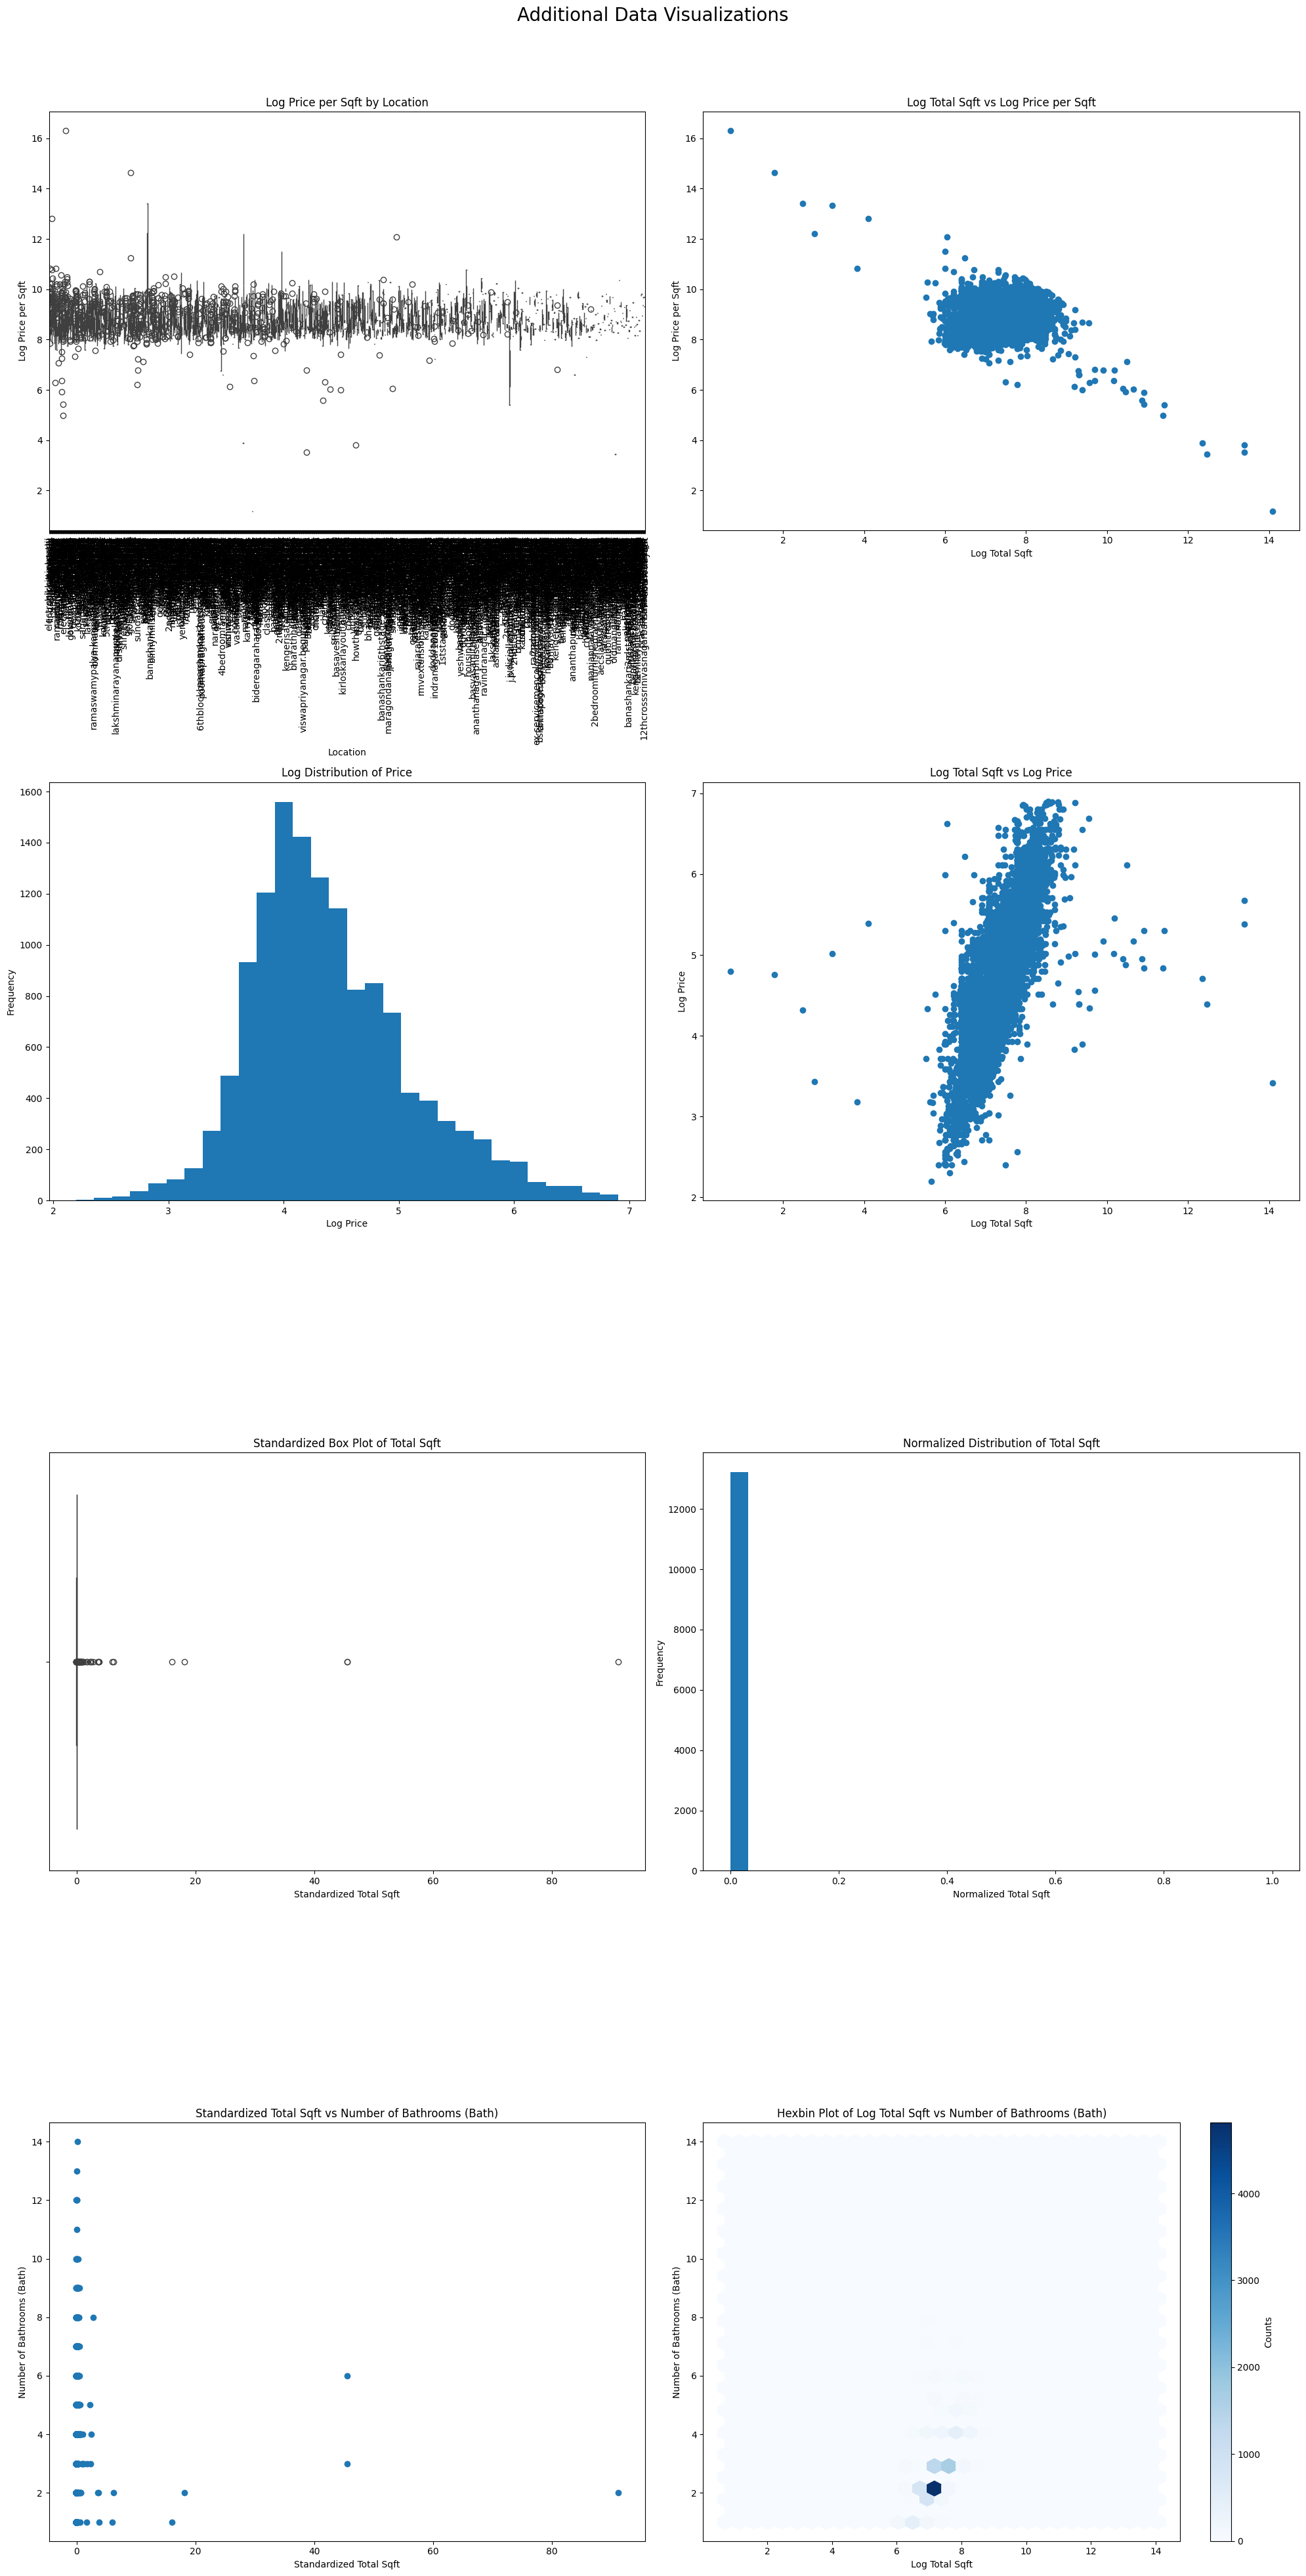

In [33]:
plot_data_visualizations(df8)

### Step 3: Observations from Charts

From the charts, I have identified several key observations:

**Extreme Price Values:** There are properties with exceptionally high and low price per square foot.
**Properties with Unusually High Square Footage Relative to the Number of Bathrooms:** These may indicate potential data entry errors or unusual property features.
**Properties with Very Low Square Footage (e.g., below 200 sqft):** These are considered outliers and may require exclusion.


### Step 4: Outlier Removal for Log-Price and Total Square Footage
In this code cell, we focus on outlier detection and removal to refine our dataset for more accurate analysis. We first address outliers in the `log_price_per_sqft` column by filtering the data to exclude extreme values beyond the 1st and 99th percentiles. Next, we handle outliers in the `total_sqft` column by standardizing the values and removing those that fall outside 3 standard deviations from the mean. This cleaning process aims to enhance the quality of the dataset, ensuring that our subsequent analysis is based on more reliable and representative data. Finally, we reset the DataFrame index to maintain a clean dataset structure.

In [34]:
# Calculate 1st and 99th percentiles
low_percentile = df8['log_price_per_sqft'].quantile(0.01)
high_percentile = df8['log_price_per_sqft'].quantile(0.99)

# Remove outliers
df = df8[(df8['log_price_per_sqft'] >= low_percentile) & (df8['log_price_per_sqft'] <= high_percentile)]

# 2. Remove total sqft outliers

# Standardize total_sqft
df8['standardized_total_sqft'] = stats.zscore(df['total_sqft'])

# Remove points beyond 3 standard deviations
df8 = df8[np.abs(df8['standardized_total_sqft']) <= 3]

# Reset index after removing rows
df8 = df8.reset_index(drop=True)

print(f"Shape of DataFrame after outlier removal: {df8.shape}")

Shape of DataFrame after outlier removal: (12670, 18)


### Step 5: Filter Out Unlikely Bathroom Counts
We remove rows where properties with less than 2000 square feet have 4 or more bathrooms, as such cases are considered improbable. This helps in refining the dataset to better reflect realistic property characteristics.

In [35]:
# Filter rows based on conditions
df9 = df8[~((df8['bath'] >= 4) & (df8['total_sqft'] < 2000))]
df9.shape


(11857, 18)

### Step 6: Filter Out Small Properties
We remove houses with a total square footage of less than 300, as this is below the typical benchmark for a 1 BHK flat. This step helps prevent skewing the dataset with unusually small properties.

In [36]:
df10 = df9[~(df9['total_sqft'] < 300)]
df10.shape


(11853, 18)

### Step 7: Reapply Visualization Function

We will reapply the visualization function to review the dataset and identify any potential outliers or anomalies that may have been missed during previous cleaning steps. By generating updated plots, we ensure a thorough examination of the data and confirm that all relevant issues have been addressed.

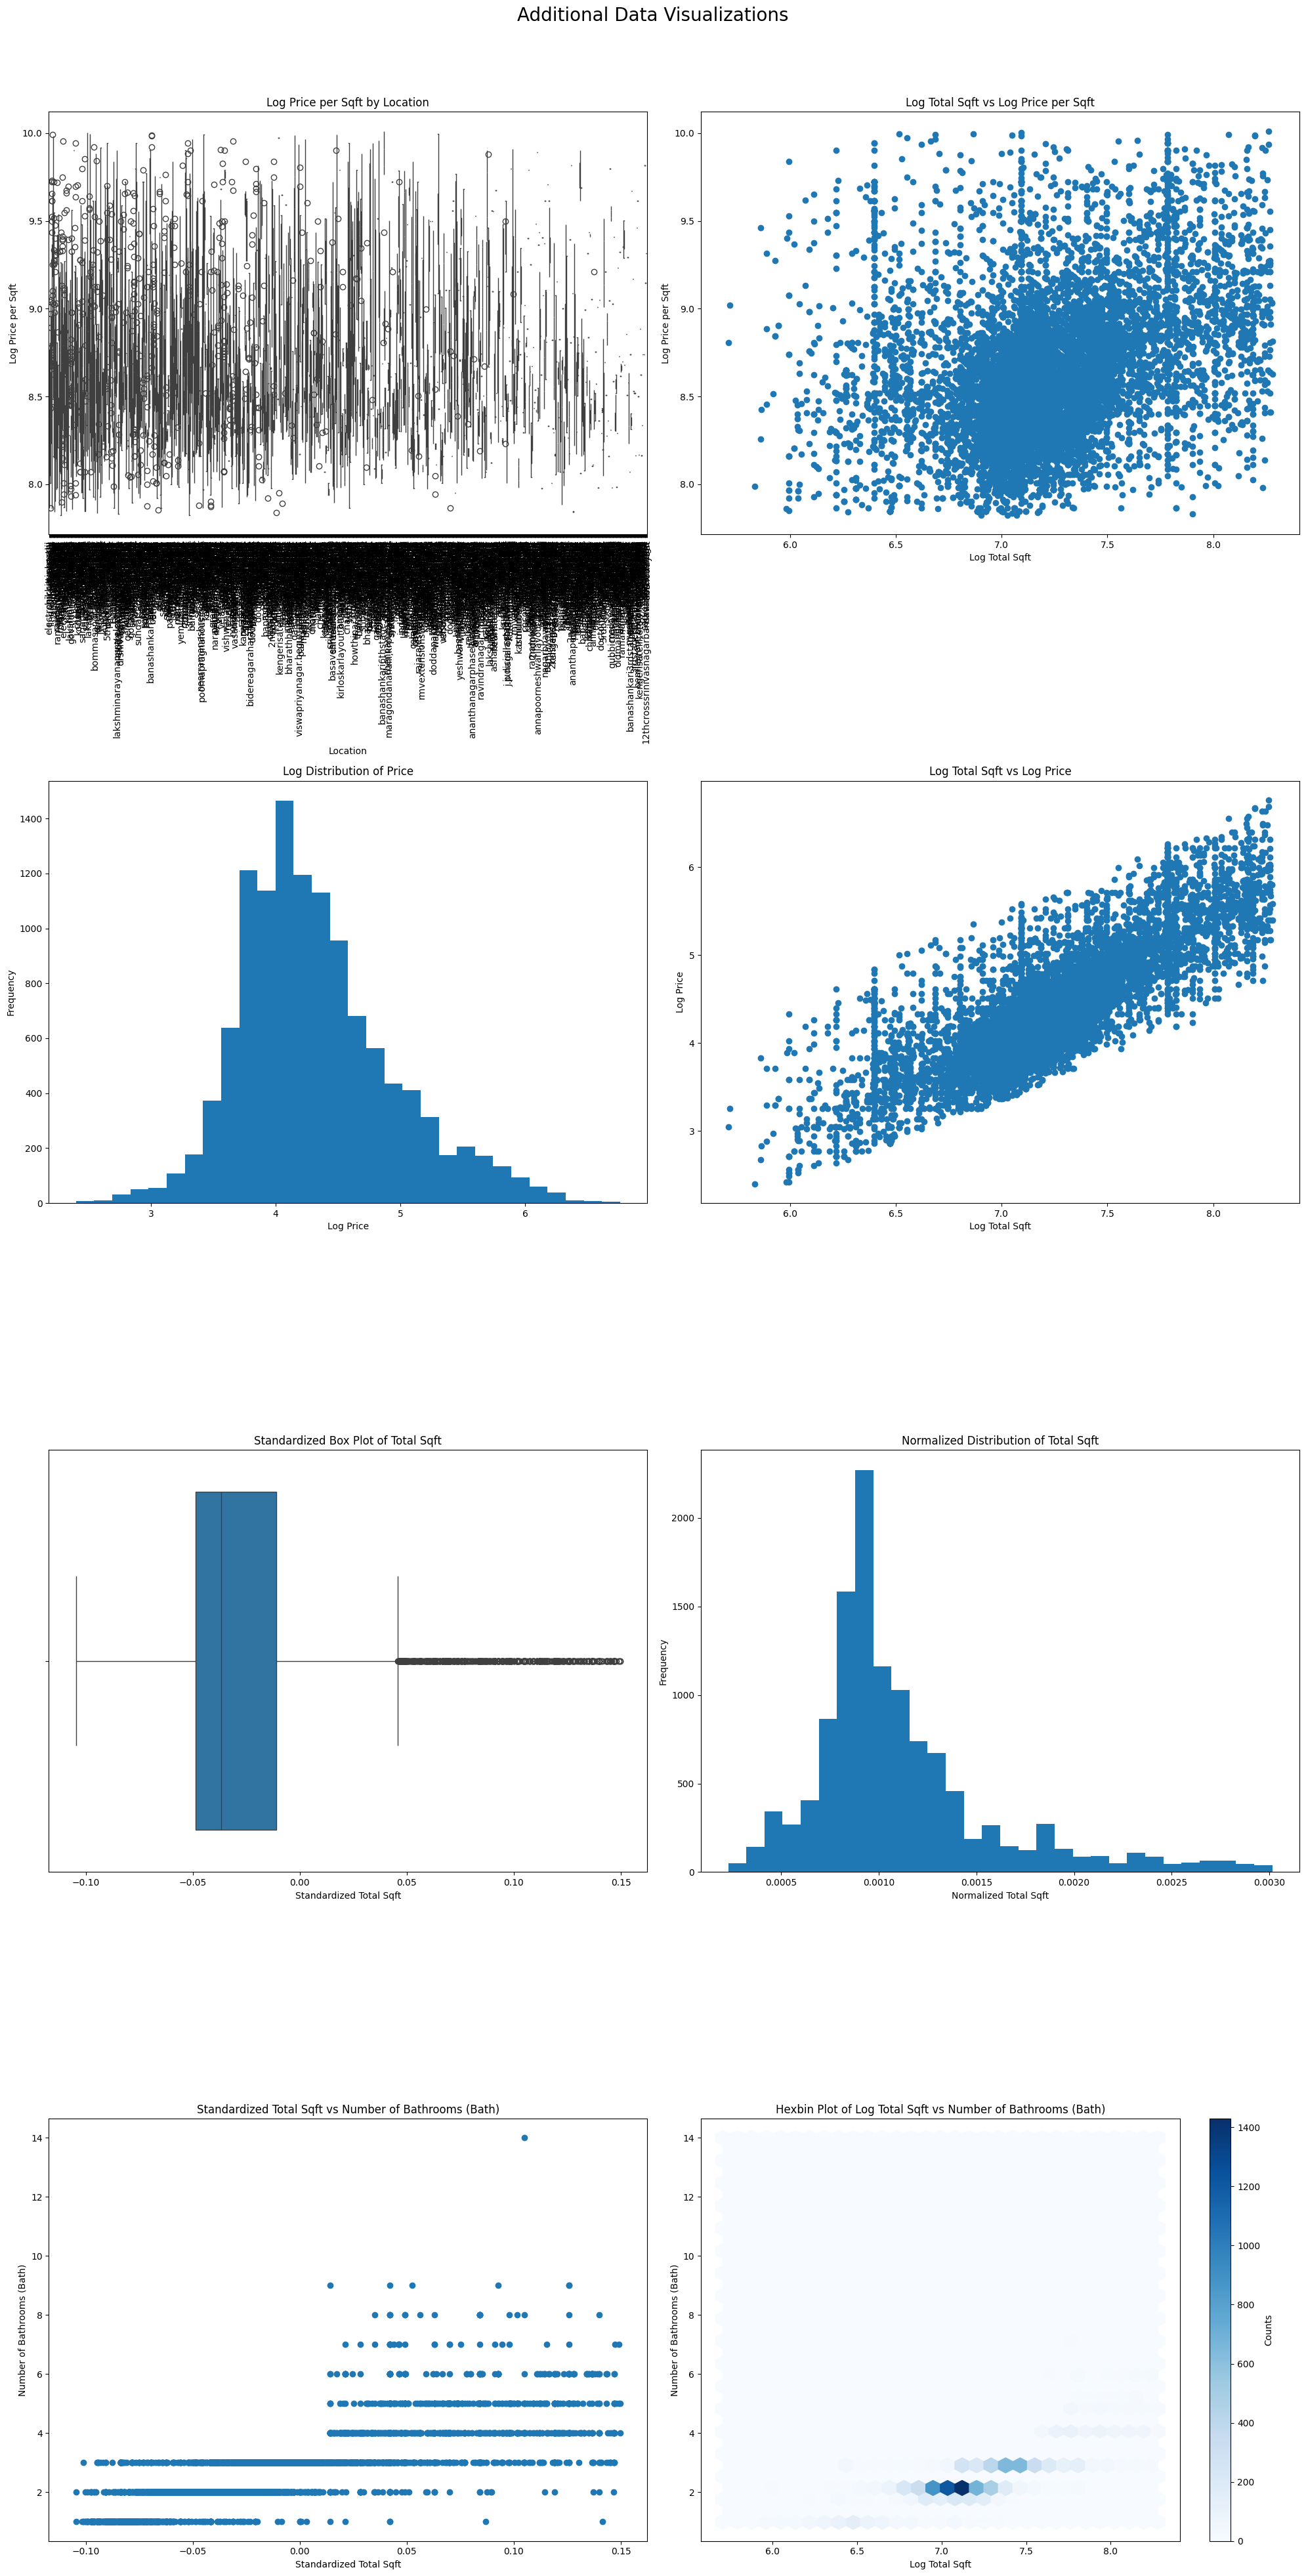

In [37]:
plot_data_visualizations(df10)

### Final Review of Outlier Removal

Aside from the expected density of data in the lower price ranges, no additional anomalies are observed. This pattern is typical in real estate data, where lower-cost areas generally have higher sales volumes compared to higher-cost areas. The visual inspection confirms that the dataset appears consistent with real-world expectations.

## Choosing Mean Encoding for Location Values

Mean encoding was selected for location values to effectively capture location-specific price trends while mitigating the risk of overfitting. This method balances the influence of less frequent locations with the overall global mean, providing a more stable and reliable representation of location-based price variations.

### Step 1: Initial Mean Encoding

In this cell, we calculate the mean price for each location and map these mean values to the original DataFrame as `location_encoded`. This step provides a basic mean encoding based on the location's average price.

In [64]:
mean_prices = df10.groupby('standardized_location')['price'].mean()

# Map the mean prices to the original DataFrame
df10['location_encoded'] = df10['standardized_location'].map(mean_prices)

print(df10['location_encoded'])

0         44.740400
1        114.062500
2         54.485706
3        115.409545
4         83.162712
            ...    
12665    118.652632
12666     95.710051
12667    211.428571
12668     58.808503
12669     43.996552
Name: location_encoded, Length: 11853, dtype: float64


C:\Users\91931\AppData\Local\Temp\ipykernel_10792\2600069555.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df10['location_encoded'] = df10['standardized_location'].map(mean_prices)


### Step 2: Smoothed Mean Encoding
Here, we refine the mean encoding by applying smoothing to account for locations with fewer observations. We calculate a global mean and use a smoothing parameter to blend the location-specific mean with the global mean. This approach helps to stabilize the encoding and reduce the impact of sparse data, resulting in a more balanced representation of location values.

In [65]:
# Calculate the global mean of the target variable
global_mean = df10['price'].mean()

# Define the smoothing parameter
m = 3

# Apply smoothing to the target encoding
def smooth_mean_encoding(col, target, m, global_mean):
    agg = df10.groupby(col)[target].agg(['mean', 'count'])
    mean_encoded = (agg['count'] * agg['mean'] + m * global_mean) / (agg['count'] + m)
    return mean_encoded

# Apply the smooth mean encoding to the 'standardized_location' column
mean_encoded = smooth_mean_encoding('standardized_location', 'price', m, global_mean)
df10['location_encoded'] = df10['standardized_location'].map(mean_encoded)

print(df10['location_encoded'])


0         45.861692
1        110.670871
2         55.120648
3        112.670262
4         83.618493
            ...    
12665    116.745038
12666     95.691017
12667    175.774655
12668     59.404509
12669     48.551455
Name: location_encoded, Length: 11853, dtype: float64


C:\Users\91931\AppData\Local\Temp\ipykernel_10792\2135798321.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df10['location_encoded'] = df10['standardized_location'].map(mean_encoded)


In [40]:
df10.head()

,total_sqft,bath,balcony,price,bhk,price_per_sqft,availability_binary,standardized_location,log_total_sqft,log_price,log_price_per_sqft,std_total_sqft,std_price,std_price_per_sqft,norm_total_sqft,norm_price,norm_price_per_sqft,standardized_total_sqft,location_encoded
0,1056.0,2.0,1.0,39.07,2.0,3699.81,0,electroniccityphaseii,6.963190,3.690628,8.216307,-0.051716,-0.637914,-0.038707,0.000807,0.031479,0.000308,-0.565018,45.861692
1,2600.0,5.0,3.0,120.00,4.0,4615.38,1,chikkatirupathi,7.863651,4.795791,8.437366,0.056086,0.131356,-0.030120,0.001989,0.113475,0.000384,1.339606,110.670871
2,1440.0,2.0,3.0,62.00,3.0,4305.56,1,uttarahalli,7.273093,4.143135,8.367895,-0.024905,-0.419955,-0.033026,0.001101,0.054711,0.000359,-0.091329,55.120648
3,1521.0,3.0,1.0,95.00,3.0,6245.89,1,lingadheeranahalli,7.327781,4.564348,8.739839,-0.019250,-0.106278,-0.014826,0.001163,0.088146,0.000520,0.008590,112.670262
4,1200.0,2.0,1.0,51.00,2.0,4250.00,1,kothanur,7.090910,3.951244,8.354910,-0.041662,-0.524514,-0.033547,0.000918,0.043566,0.000354,-0.387385,83.618493


## Finalize Dataset by Dropping Unnecessary Columns

We will now drop the `standardized_location` column and the following additional columns to clean up the dataset: `log_total_sqft`, `log_price`, `std_total_sqft`, `std_price`, `std_price_per_sqft`, `norm_total_sqft`, `norm_price`, `norm_price_per_sqft`, `log_price_per_sqft`, and `standardized_total_sqft`. This will result in a final dataset consisting solely of relevant float values, ready for further analysis.

In [41]:
# drop the following columns standardized_location	log_total_sqft	log_price	std_total_sqft	std_price	std_price_per_sqft	norm_total_sqft	norm_price	norm_price_per_sqft	log_price_per_sqft	standardized_total_sqft

df11 = df10.drop(['standardized_location', 'log_total_sqft', 'log_price', 'std_total_sqft',
                   'std_price', 'std_price_per_sqft', 'norm_total_sqft', 'norm_price',
                   'norm_price_per_sqft', 'log_price_per_sqft', 'standardized_total_sqft'], axis='columns')
df11.head(30)


,total_sqft,bath,balcony,price,bhk,price_per_sqft,availability_binary,location_encoded
0,1056.0,2.0,1.0,39.07,2.0,3699.81,0,45.861692
1,2600.0,5.0,3.0,120.00,4.0,4615.38,1,110.670871
2,1440.0,2.0,3.0,62.00,3.0,4305.56,1,55.120648
3,1521.0,3.0,1.0,95.00,3.0,6245.89,1,112.670262
4,1200.0,2.0,1.0,51.00,2.0,4250.00,1,83.618493
5,1170.0,2.0,1.0,38.00,2.0,3247.86,1,95.691017
6,2732.0,4.0,0.0,204.00,4.0,7467.06,0,176.455460
7,3300.0,4.0,0.0,600.00,4.0,18181.82,1,263.424538
8,1310.0,3.0,1.0,63.25,3.0,4828.24,1,93.080162
9,1800.0,2.0,2.0,70.00,3.0,3888.89,0,95.691017


In [42]:
df11.shape

(11853, 8)

In [43]:
# # Save DataFrame to CSV with an absolute path
# df11.to_csv('data/transformed_and_cleaned_data.csv', index=False)


## Real Estate Price Prediction Model

### Step 1: Train-Test Split

First, we split our dataset into training, testing and validation sets.

In [44]:
# Features and target
X = df11.drop('price', axis=1)
y = df11['price']

# First split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Further split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verifying the shapes of the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)



Training set shape: (7111, 7) (7111,)
Validation set shape: (2371, 7) (2371,)
Test set shape: (2371, 7) (2371,)


### Step 2: Evaluating Multiple Models
We will evaluate multiple regression models to determine which one performs best on our data. This includes Linear Regression, Decision Tree, Random Forest, Gradient Boosting, and XGBoost.

In [45]:
# Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor()
}

# Cross-validation and metrics evaluation
for name, model in models.items():
    # Cross-validation for MSE
    mse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-mse_scores)

    # Cross-validation for MAE
    mae_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae_scores = -mae_scores

    # Cross-validation for R²
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Print metrics
    print(f"{name} - RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std():.4f})")
    print(f"{name} - MAE: {mae_scores.mean():.4f} (+/- {mae_scores.std():.4f})")
    print(f"{name} - R²: {r2_scores.mean():.4f} (+/- {r2_scores.std():.4f})")
    print()  # For better readability


Linear Regression - RMSE: 20.9016 (+/- 1.8885)
Linear Regression - MAE: 12.2287 (+/- 0.5269)
Linear Regression - R²: 0.9264 (+/- 0.0059)

Decision Tree - RMSE: 6.3020 (+/- 0.7663)
Decision Tree - MAE: 2.1724 (+/- 0.1934)
Decision Tree - R²: 0.9931 (+/- 0.0006)

Random Forest - RMSE: 3.5518 (+/- 1.0147)
Random Forest - MAE: 1.0441 (+/- 0.1348)
Random Forest - R²: 0.9977 (+/- 0.0012)

Gradient Boosting - RMSE: 4.2339 (+/- 0.3608)
Gradient Boosting - MAE: 2.2855 (+/- 0.1040)
Gradient Boosting - R²: 0.9970 (+/- 0.0005)

XGBoost - RMSE: 3.8673 (+/- 0.8493)
XGBoost - MAE: 1.6033 (+/- 0.1175)
XGBoost - R²: 0.9974 (+/- 0.0011)



### Step 3: Hyperparameter Tuning for Random Forest Regressor

In this step, we will perform hyperparameter tuning for the Random Forest Regressor using Randomized Search with Cross-Validation. Random Forest has been chosen for this task because it currently shows the most promise among the evaluated models, demonstrating superior performance metrics.

In [46]:
# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Instantiate the Random Forest Regressor
rf = RandomForestRegressor()

# Perform Randomized Search with Cross-Validation
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

# Print the best parameters
best_params = rf_random.best_params_
print("Best Parameters:", best_params)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}


### Step 4: Train Final Random Forest Model with Optimal Parameters
In this step, we will train the final Random Forest model using the best hyperparameters identified during the hyperparameter tuning phase. By applying these optimal parameters, we aim to maximize the model’s performance and accuracy, ensuring that it is well-tuned for the given dataset.

In [47]:
# Train the final model with the best parameters
best_rf = rf_random.best_estimator_
best_rf.fit(X_train, y_train)

# Predictions on the test set
y_pred = best_rf.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")

# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f"Test R²: {r2:.4f}")



Test RMSE: 9.5083
Test R²: 0.9858


### Step 5: Model Evaluation
In this step, we will evaluate the trained Random Forest model on the test set using two key performance metrics: RMSE (Root Mean Squared Error) and R² (R-squared). RMSE will provide insight into the average magnitude of prediction errors, while R² will indicate the proportion of variance explained by the model. This evaluation will help assess the model’s accuracy and overall effectiveness.

In [48]:
# Predictions on the training set
y_train_pred = best_rf.predict(X_train)

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"Training RMSE: {train_rmse:.4f}")

# Calculate R² for training set
train_r2 = r2_score(y_train, y_train_pred)
print(f"Training R²: {train_r2:.4f}")

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse:.4f}")

# Calculate R² for test set
test_r2 = r2_score(y_test, y_pred)
print(f"Test R²: {test_r2:.4f}")


Training RMSE: 0.0148
Training R²: 1.0000
Test RMSE: 9.5083
Test R²: 0.9858


### Step 6: Cross-Validation with Regularized Random Forest

Cross-validation is performed to assess the model's generalization ability, ensuring it performs well on unseen data and avoids overfitting. By evaluating the model with different subsets of the data, we can confirm that it maintains consistent performance and generalizes effectively across various scenarios, rather than just fitting the training data.

In [49]:
# Perform 10-fold cross-validation
cv_scores = cross_val_score(best_rf, X, y, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print(f"Cross-Validation RMSE Scores: {cv_rmse_scores}")
print(f"Mean CV RMSE: {cv_rmse_scores.mean():.4f}")
print(f"Standard Deviation of CV RMSE: {cv_rmse_scores.std():.4f}")


Cross-Validation RMSE Scores: [8.46478898 8.74478086 9.58516268 9.05973007 9.14071954 7.5472488
 8.27694028 6.59693555 8.13440927 6.4345745 ]
Mean CV RMSE: 8.1985
Standard Deviation of CV RMSE: 1.0016


In [50]:
# Regularized Random Forest with tuned hyperparameters
rf_regularized = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    random_state=42
)

# Cross-Validation with Regularized Random Forest
cv_scores_regularized = cross_val_score(rf_regularized, X, y, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores_regularized = np.sqrt(-cv_scores_regularized)

print(f"Regularized Cross-Validation RMSE Scores: {cv_rmse_scores_regularized}")
print(f"Mean Regularized CV RMSE: {cv_rmse_scores_regularized.mean():.4f}")
print(f"Standard Deviation of Regularized CV RMSE: {cv_rmse_scores_regularized.std():.4f}")


Regularized Cross-Validation RMSE Scores: [8.27483131 8.74207446 9.57083732 9.11205848 9.42303596 7.53522206
 7.90213537 6.49034916 7.89771325 6.50296772]
Mean Regularized CV RMSE: 8.1451
Standard Deviation of Regularized CV RMSE: 1.0441


### Step 7: Create Ensemble Model
n this step, we will create an ensemble model by combining XGBoost and Gradient Boosting along with Random Forest. This approach aims to harness the strengths of each model to achieve potentially better performance. The earlier benchmarks indicate the following performance metrics:

XGBoost:

*   RMSE: 3.8673 (+/- 0.8493)
*   MAE: 1.6033 (+/- 0.1175)
*   R²: 0.9974 (+/- 0.0011)

Gradient Boosting:
* RMSE: 4.2304 (+/- 0.3687)
* MAE: 2.2850 (+/- 0.1027)
* R²: 0.9969 (+/- 0.0005)

Random Forest:
* RMSE: 3.5029 (+/- 1.0351)
* MAE: 1.0507 (+/- 0.1178)
* R²: 0.9977 (+/- 0.0013)

By combining these models, we aim to improve upon the individual performances and achieve a more robust and accurate predictive model.

In [51]:
# Define the individual models
model1 = RandomForestRegressor(**best_params, random_state=42)
model2 = GradientBoostingRegressor(random_state=42)
model3 = xgb.XGBRegressor(random_state=42)

# Create the ensemble model
ensemble_model = VotingRegressor(estimators=[('rf', model1), ('gb', model2), ('xgb', model3)])

# Perform Cross-Validation with the Ensemble Model
cv_scores_ensemble = cross_val_score(ensemble_model, X, y, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores_ensemble = np.sqrt(-cv_scores_ensemble)

print(f"Ensemble Cross-Validation RMSE Scores: {cv_rmse_scores_ensemble}")
print(f"Mean Ensemble CV RMSE: {cv_rmse_scores_ensemble.mean():.4f}")
print(f"Standard Deviation of Ensemble CV RMSE: {cv_rmse_scores_ensemble.std():.4f}")


Ensemble Cross-Validation RMSE Scores: [3.24219438 3.99121461 4.97173717 4.14723592 4.956218   3.06005243
 3.50362207 2.97240338 3.55493582 3.17132262]
Mean Ensemble CV RMSE: 3.7571
Standard Deviation of Ensemble CV RMSE: 0.7025


### Step 8: Train and Evaluate the Ensemble Model
In this step, we will train the ensemble model, which combines XGBoost, Gradient Boosting, and Random Forest, on the entire training set. Following training, we will evaluate the ensemble model on both the test set and a separate validation set. Testing on the validation set provides an additional layer of evaluation, offering a further check on the model's ability to generalize and perform well on unseen data. This dual evaluation approach will help us gain comprehensive insights into the model's predictive accuracy and effectiveness, allowing us to determine if the ensemble approach delivers improved performance compared to the individual models.

In [52]:
# Train the ensemble model on the entire training set
ensemble_model.fit(X_train, y_train)

# Evaluate the ensemble model on the test set
y_pred_ensemble = ensemble_model.predict(X_test)

# Predictions on the validation set using the ensemble model
y_pred_ensemble_val = ensemble_model.predict(X_val)

# Calculate RMSE and R² for the test set
test_rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
test_r2_ensemble = r2_score(y_test, y_pred_ensemble)

# Calculate RMSE and R² for the validation set
rmse_ensemble_val = np.sqrt(mean_squared_error(y_val, y_pred_ensemble_val))
print(f"Ensemble Validation RMSE: {rmse_ensemble_val:.4f}")

# Calculate for the validation set
r2_ensemble_val = r2_score(y_val, y_pred_ensemble_val)
print(f"Ensemble Validation R²: {r2_ensemble_val:.4f}")
print(f"Ensemble Test RMSE: {test_rmse_ensemble:.4f}")
print(f"Ensemble Test R²: {test_r2_ensemble:.4f}")


Ensemble Validation RMSE: 4.5558
Ensemble Validation R²: 0.9968
Ensemble Test RMSE: 4.4546
Ensemble Test R²: 0.9969


## Predictions and Model Performance Visualization

### Scatter Plot for Ensemble Model Predictions
This cell presents a scatter plot comparing the actual prices to the predicted prices using the ensemble model. Performance metrics are included in a text box on the plot for quick reference.

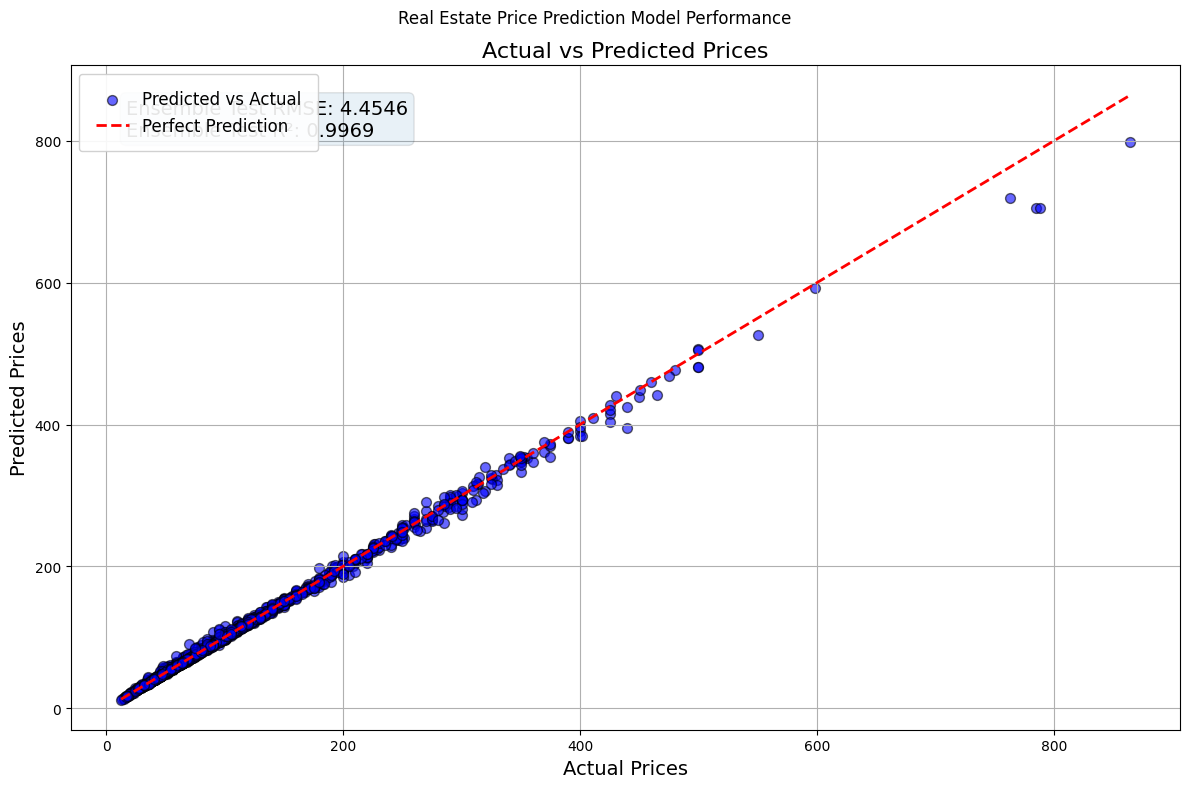

In [53]:
# Predictions on the test set using the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)

# Scatter plot of actual vs. predicted prices
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred_ensemble, alpha=0.6, color='blue', edgecolor='k', s=50, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

# Add text box with metrics
textstr = '\n'.join((
    f'Ensemble Test RMSE: {test_rmse_ensemble:.4f}',
    f'Ensemble Test R²: {test_r2_ensemble:.4f}',
))

# Place a text box in upper left in axes coords
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

# Plot details
plt.xlabel('Actual Prices', fontsize=14)
plt.ylabel('Predicted Prices', fontsize=14)
plt.title('Actual vs Predicted Prices', fontsize=16)
plt.suptitle('Real Estate Price Prediction Model Performance', fontsize=12)

# Improve the legend
plt.legend(loc='upper left', fontsize=12, frameon=True, fancybox=True, framealpha=0.9, borderpad=1)

plt.grid(True)
plt.tight_layout()

plt.show()


### Residuals Plot
In this cell, we plot the residuals (the differences between actual and predicted prices) to identify any patterns or biases in the predictions. This plot helps us understand how well the model is performing and if there are any systematic errors.

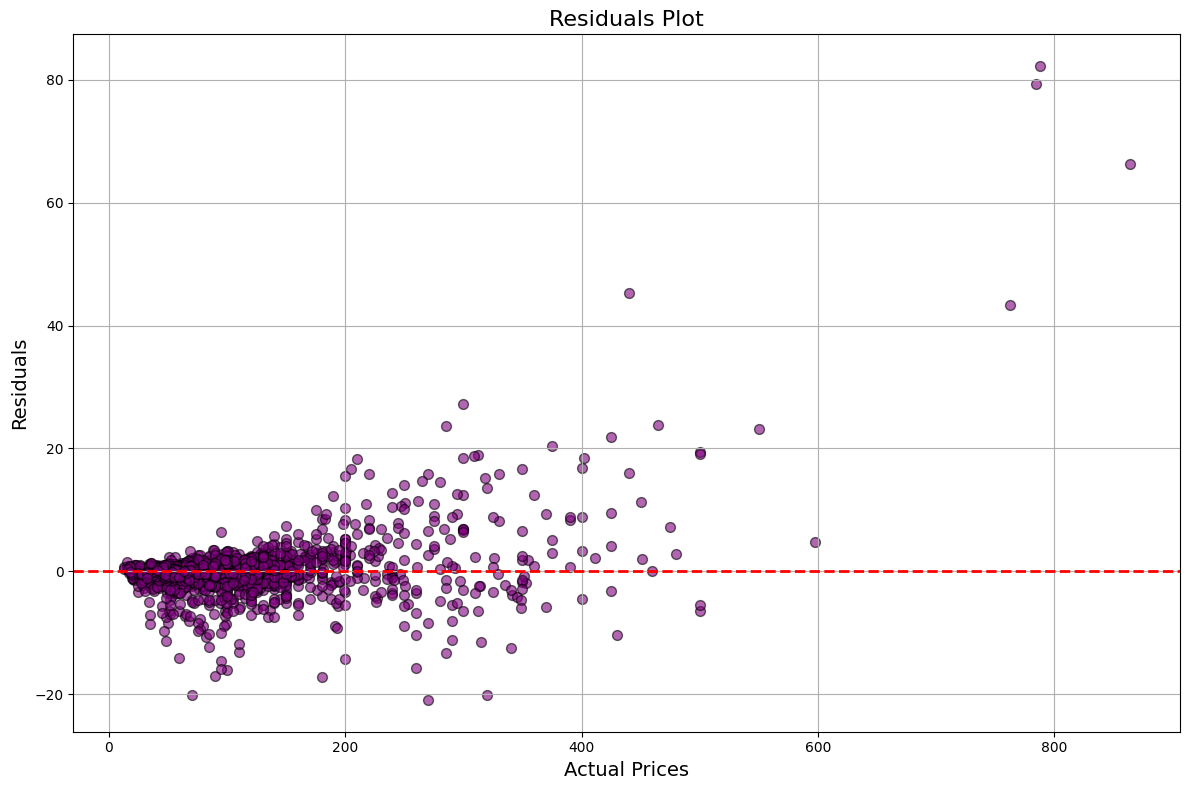

In [54]:
# Residuals plot
residuals = y_test - y_pred_ensemble

plt.figure(figsize=(12, 8))
plt.scatter(y_test, residuals, alpha=0.6, color='purple', edgecolor='k', s=50)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Prices', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals Plot', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


### Feature Importances
This cell visualizes the importance of each feature in the Random Forest model within the ensemble. It helps us understand which features have the most influence on the predictions.

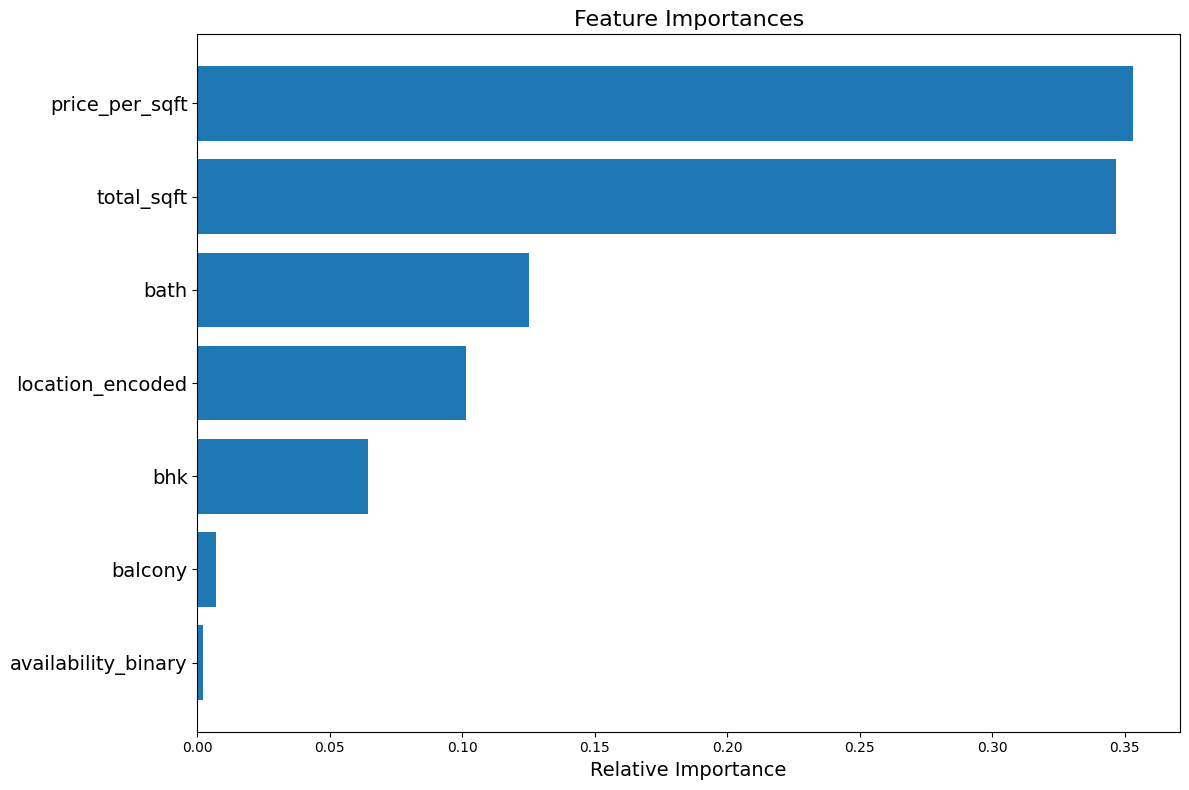

In [55]:
importances = ensemble_model.named_estimators_['rf'].feature_importances_
features = X_train.columns
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances', fontsize=16)
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=14)
plt.xlabel('Relative Importance', fontsize=14)
plt.tight_layout()
plt.show()


### Histogram of Actual vs Predicted Prices
In this cell, we plot histograms of actual and predicted prices to compare their distributions. This visualization helps us understand how well the model's predictions match the actual data distribution.

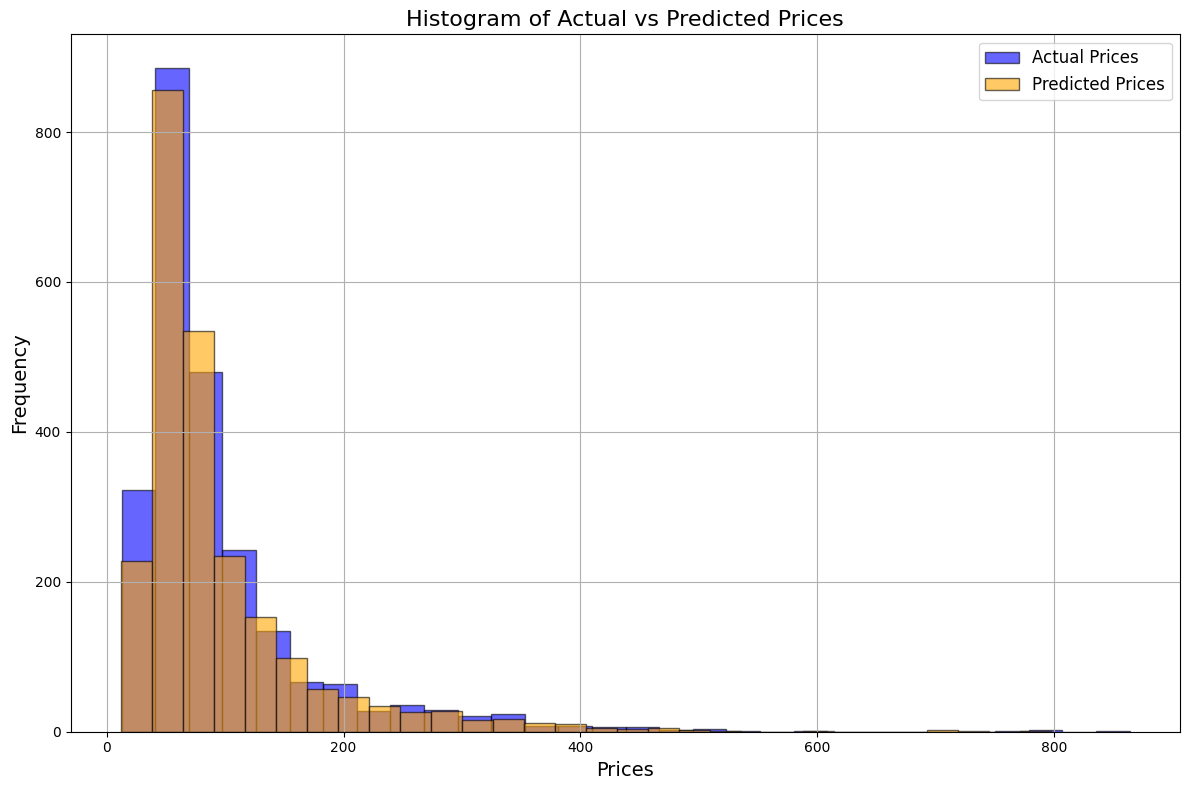

In [56]:
plt.figure(figsize=(12, 8))
plt.hist(y_test, bins=30, alpha=0.6, label='Actual Prices', color='blue', edgecolor='k')
plt.hist(y_pred_ensemble, bins=30, alpha=0.6, label='Predicted Prices', color='orange', edgecolor='k')
plt.xlabel('Prices', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of Actual vs Predicted Prices', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


### Cumulative Gains Chart
This cell generates a cumulative gains chart, which is a useful tool to evaluate the model's performance by comparing the gains of the model to a random model (baseline).

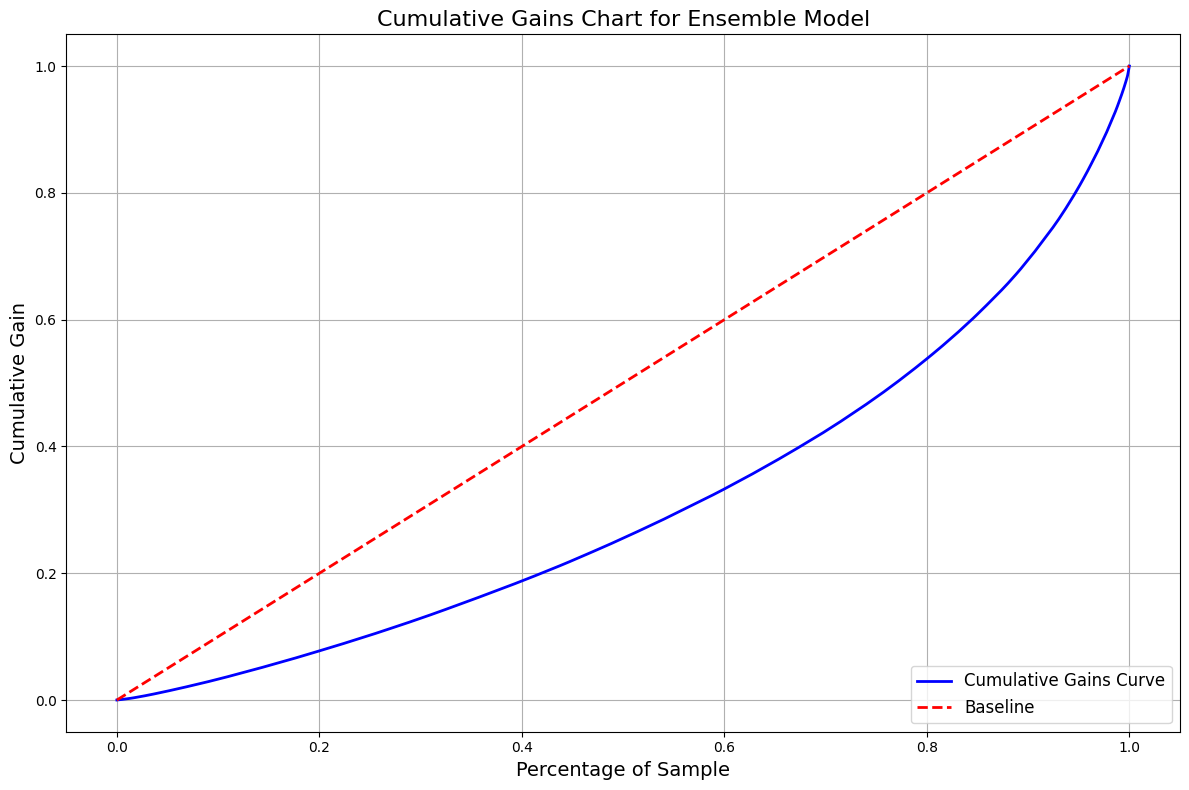

In [57]:
# Assuming ensemble_model is your trained ensemble model and you have y_test, y_pred_ensemble
y_pred_ensemble = ensemble_model.predict(X_test)

# Sort the predictions and actual values based on the predictions
sorted_indices = np.argsort(y_pred_ensemble)
y_test_sorted = np.array(y_test)[sorted_indices]
y_pred_sorted = np.array(y_pred_ensemble)[sorted_indices]

# Calculate cumulative gains
cumulative_gains = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)
baseline = np.linspace(0, 1, len(cumulative_gains))

# Plot cumulative gains
plt.figure(figsize=(12, 8))
plt.plot(baseline, cumulative_gains, color='blue', label='Cumulative Gains Curve', linewidth=2)
plt.plot(baseline, baseline, color='red', linestyle='--', linewidth=2, label='Baseline')
plt.xlabel('Percentage of Sample', fontsize=14)
plt.ylabel('Cumulative Gain', fontsize=14)
plt.title('Cumulative Gains Chart for Ensemble Model', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


### Prediction Error Distribution
This cell visualizes the distribution of prediction errors (residuals) using a kernel density plot. It helps us understand the spread and center of the errors.

C:\Users\91931\AppData\Local\Temp\ipykernel_10792\2810863429.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True, color='purple')


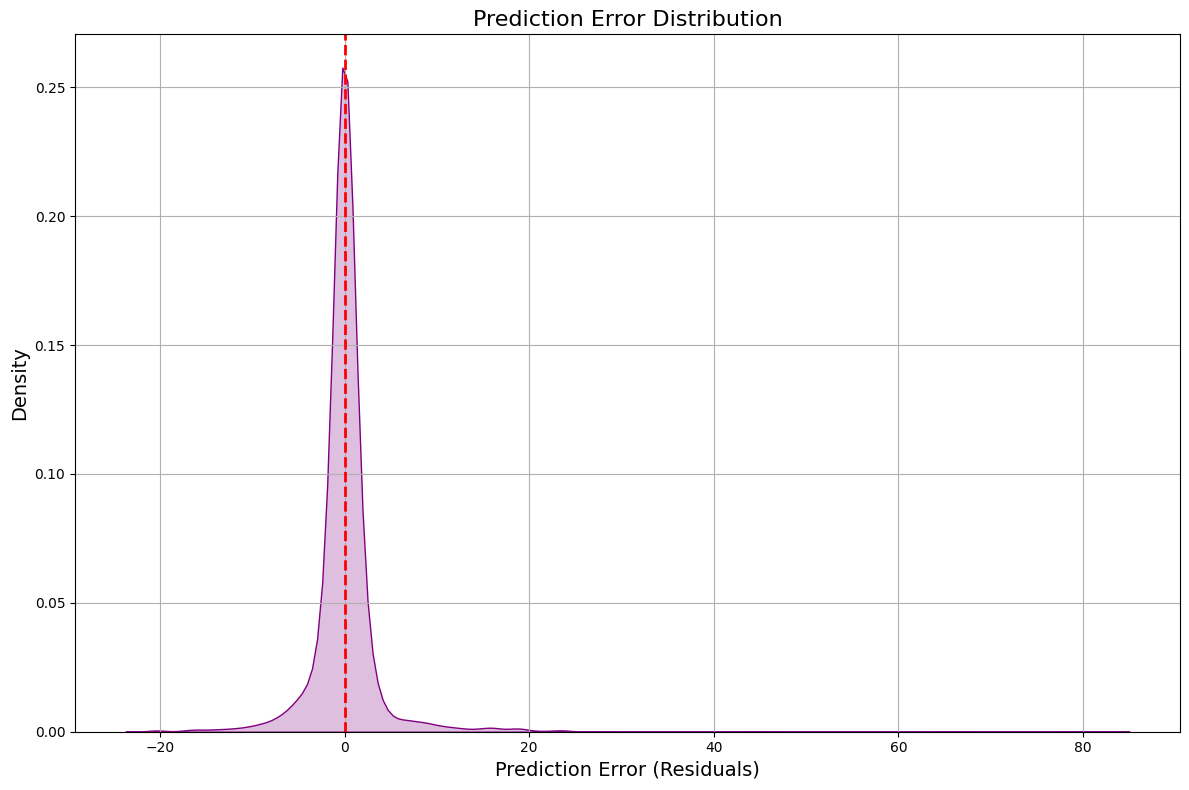

In [58]:
plt.figure(figsize=(12, 8))
sns.kdeplot(residuals, shade=True, color='purple')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Prediction Error (Residuals)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Prediction Error Distribution', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


### Correlation Matrix Heatmap
This cell displays a heatmap of the correlation matrix to visualize the relationships between different features in the dataset. This helps us understand the strength and direction of relationships between variables.

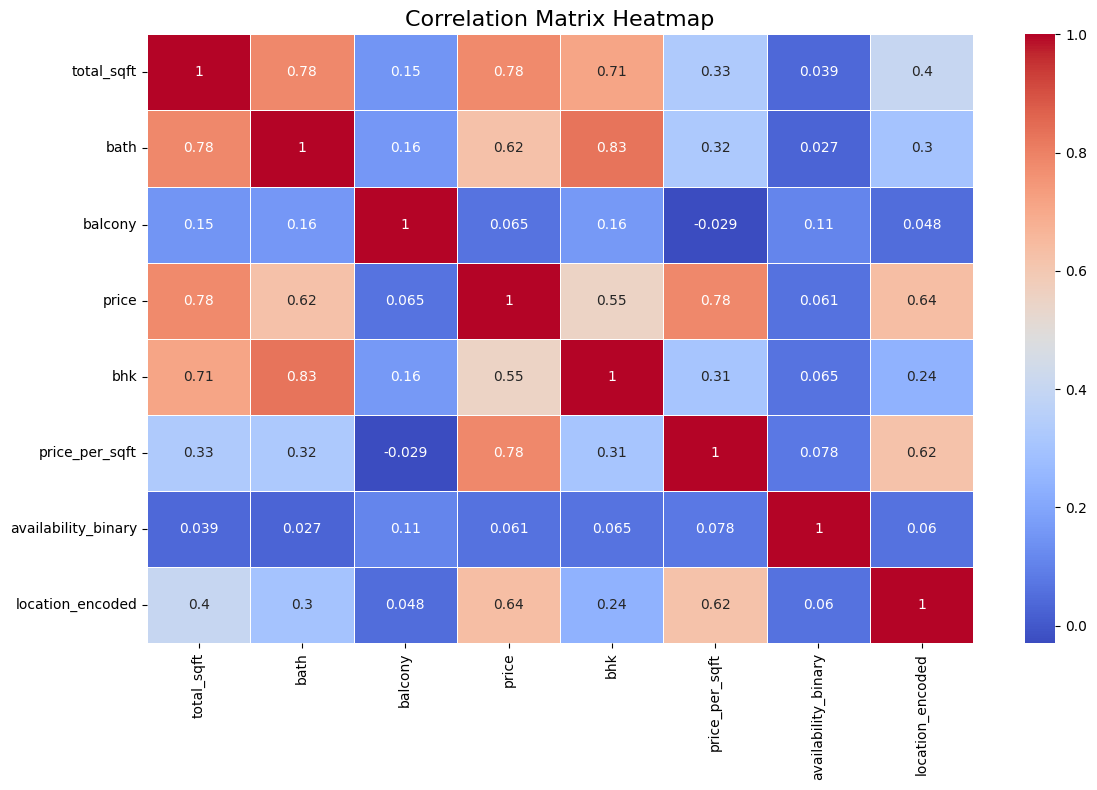

In [59]:
correlation_matrix = df11.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.tight_layout()
plt.show()


### Median Absolute Percentage Error (MedAPE)
This cell calculates and prints the Median Absolute Percentage Error (MedAPE) to measure the accuracy of the model's predictions.

In [60]:
# Calculate absolute percentage error for each prediction
ape = np.abs((y_test - y_pred_ensemble) / y_test) * 100

# Calculate the median absolute percentage error
medape = np.median(ape)

print(f'Median Absolute Percentage Error (MedAPE): {medape:.2f}%')


Median Absolute Percentage Error (MedAPE): 0.95%
